# Dataset Loading and Visualization

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# Load the dataset
df = pd.read_csv('/content/AI_in_HealthCare_Dataset.csv')
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()

Dataset Shape: (5000, 20)

Columns: ['Patient_ID', 'Age', 'Gender', 'Blood_Pressure', 'Heart_Rate', 'Temperature', 'Diagnosis', 'Medication', 'Treatment_Duration', 'Insurance_Type', 'Doctor_Name', 'Hospital_Name', 'Lab_Test_Results', 'X-ray_Results', 'Surgery_Type', 'Recovery_Time', 'Allergies', 'Family_History', 'Patient_Satisfaction', 'AI_Diagnosis_Confidence']


,Patient_ID,Age,Gender,Blood_Pressure,Heart_Rate,Temperature,Diagnosis,Medication,Treatment_Duration,Insurance_Type,Doctor_Name,Hospital_Name,Lab_Test_Results,X-ray_Results,Surgery_Type,Recovery_Time,Allergies,Family_History,Patient_Satisfaction,AI_Diagnosis_Confidence
0,1,62,Female,102.349134,79.827209,98.912361,Hypertension,Statins,24,Uninsured,Dr. Brown,Children's Hospital,114.906151,Abnormal,Appendectomy,5,Latex,Heart Disease,3,0.917404
1,2,65,Male,137.760933,72.817449,98.912508,Hypertension,Insulin,29,Uninsured,Dr. Wang,Healthcare Clinic,88.556974,Normal,Knee Replacement,2,Shellfish,Diabetes,4,0.811706
2,3,82,Male,97.618564,57.135424,99.189728,Influenza,Chemotherapy,15,Private,Dr. Johnson,Children's Hospital,106.705047,Normal,Gallbladder Removal,7,NaN,Hypertension,2,0.802673
3,4,85,Male,121.743752,67.355838,96.033487,Heart Disease,Chemotherapy,5,Private,Dr. Smith,Healthcare Clinic,83.043268,Normal,Cataract Surgery,7,Latex,Hypertension,5,0.816811
4,5,85,Male,129.530450,64.849416,99.077675,Heart Disease,Insulin,10,Private,Dr. Lee,Children's Hospital,85.543826,Abnormal,Appendectomy,9,Shellfish,Diabetes,1,0.750850


# Data Preprocessing

In [ ]:
# Remove unnecessary features
columns_to_drop = ['Patient_ID', 'Doctor_Name', 'Hospital_Name']
df_clean = df.drop(columns=columns_to_drop)

# Define feature types
numeric_features = ['Age', 'Blood_Pressure', 'Heart_Rate', 'Temperature',
                   'Treatment_Duration', 'Lab_Test_Results', 'Recovery_Time',
                   'Patient_Satisfaction']
categorical_features = ['Gender', 'Insurance_Type',
                       'X-ray_Results', 'Surgery_Type', 'Family_History', 'Allergies']

# Handle missing values
for col in numeric_features:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

for col in categorical_features:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Prepare target variables
diagnosis_encoder = LabelEncoder()
medication_encoder = LabelEncoder()

df_clean['Diagnosis_Encoded'] = diagnosis_encoder.fit_transform(df_clean['Diagnosis'])
df_clean['Medication_Encoded'] = medication_encoder.fit_transform(df_clean['Medication'])

df_clean = df_clean.drop(columns='Diagnosis')
df_clean = df_clean.drop(columns='Medication')

num_diagnosis_classes = len(diagnosis_encoder.classes_)
num_medication_classes = len(medication_encoder.classes_)

print(f"Number of diagnosis classes: {num_diagnosis_classes}")
print(f"Number of medication classes: {num_medication_classes}")

Number of diagnosis classes: 5
Number of medication classes: 5


In [ ]:
# Encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

In [ ]:
# Scale numeric features
for col in numeric_features:
    scaler = StandardScaler()
    df_clean[col] = scaler.fit_transform(df_clean[col].values.reshape(-1, 1))

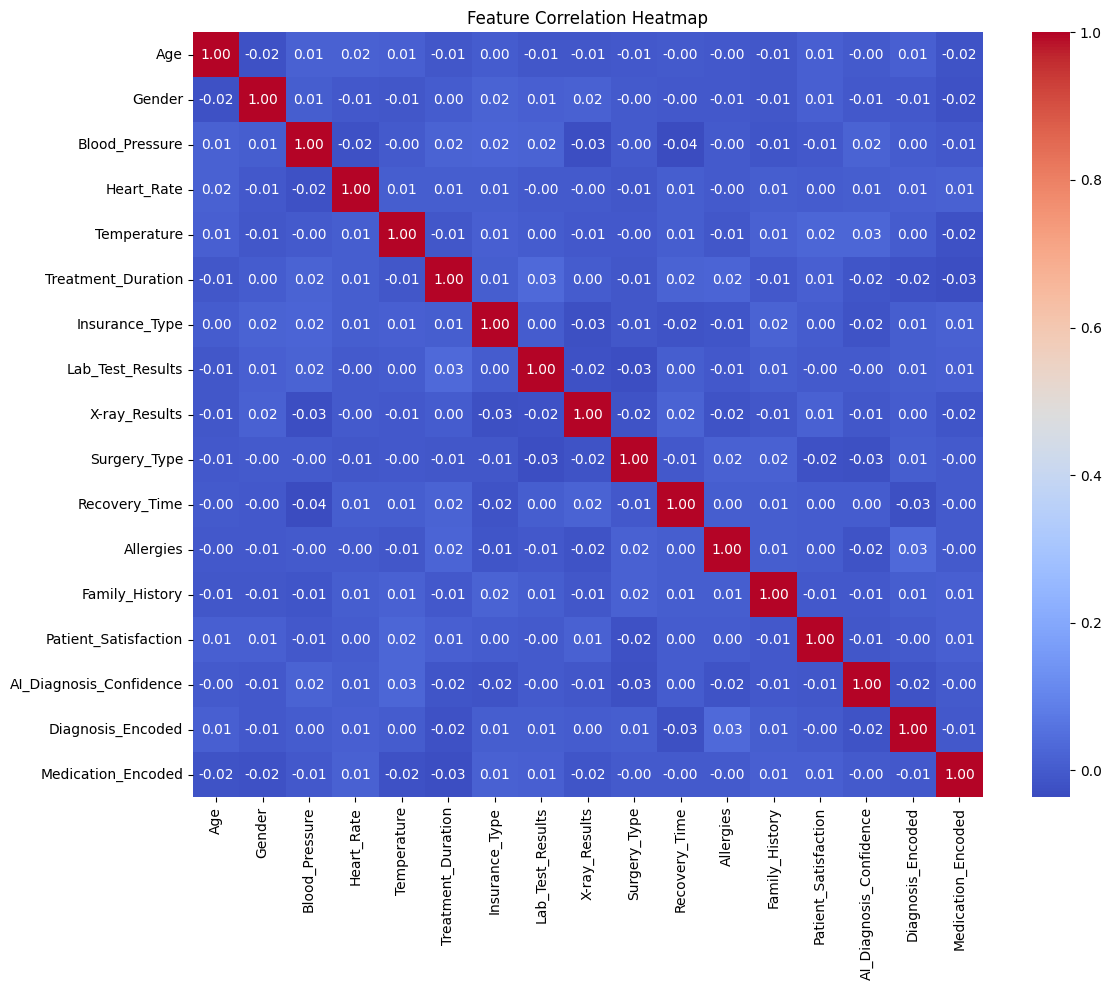


Features most relevant to the diagnosis:
Diagnosis_Encoded          1.000000
Allergies                  0.032997
Heart_Rate                 0.011379
Age                        0.009423
Lab_Test_Results           0.007289
Insurance_Type             0.006156
Surgery_Type               0.005830
Family_History             0.005581
Blood_Pressure             0.003579
Temperature                0.003059
X-ray_Results              0.001801
Patient_Satisfaction      -0.000156
Medication_Encoded        -0.005065
Gender                    -0.007412
AI_Diagnosis_Confidence   -0.016164
Treatment_Duration        -0.020184
Recovery_Time             -0.027595
Name: Diagnosis_Encoded, dtype: float64

Selected Features: ['Insurance_Type', 'Lab_Test_Results', 'X-ray_Results', 'Surgery_Type', 'Recovery_Time', 'Allergies', 'Family_History', 'Patient_Satisfaction', 'Diagnosis_Encoded', 'Medication_Encoded']


In [ ]:
# Calculate correlation matrix
correlation_matrix = df_clean.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# View the correlation with the target variable (Diagnosis)
diagnosis_correlations = correlation_matrix['Diagnosis_Encoded'].sort_values(ascending=False)
print("\nFeatures most relevant to the diagnosis:")
print(diagnosis_correlations)

# Select important features
X = df_clean.drop('AI_Diagnosis_Confidence', axis=1)
y = df_clean['AI_Diagnosis_Confidence']
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("\nSelected Features:", selected_features)

# Model Initialization

In [ ]:
class HealthcareDataset(Dataset):
    def __init__(self, X, y_diagnosis, y_medication, noise_level=0.05, augment_prob=0.4):
        # Convert input data to PyTorch tensors
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X)
        else:
            self.X = torch.FloatTensor(X.to_numpy())

        # Convert diagnosis labels to long integer tensors
        if isinstance(y_diagnosis, np.ndarray):
            self.y_diagnosis = torch.LongTensor(y_diagnosis) # Changed to LongTensor
        else:
            self.y_diagnosis = torch.LongTensor(y_diagnosis.to_numpy()) # Changed to LongTensor

         # Convert medication labels to long integer tensors
        if isinstance(y_medication, np.ndarray):
            self.y_medication = torch.LongTensor(y_medication)
        else:
            self.y_medication = torch.LongTensor(y_medication.to_numpy())

         # Set noise level and data augmentation probability
        self.noise_level = noise_level
        self.augment_prob = augment_prob

    def __len__(self):
        return len(self.X)

    def add_noise(self, x):
         # Add Gaussian noise
        noise = torch.randn_like(x) * self.noise_level
        return x + noise

    def augment(self, x):
        if torch.rand(1) < self.augment_prob:
             # Randomly scale the data
            scale = 1.0 + torch.randn(1) * 0.1
            x = x * scale

             # Randomly mask some features using bernoulli distribution
            mask = torch.bernoulli(torch.ones_like(x) * 0.9)
            x = x * mask

            # Add random offsets
            offset = torch.randn_like(x) * 0.05
            x = x + offset

            # Randomly flip some feature values
            if torch.rand(1) < 0.2:
                flip_mask = torch.bernoulli(torch.ones_like(x) * 0.1)
                x = x * (1 - flip_mask) + (-x) * flip_mask

            # Mix with a random sample
            if torch.rand(1) < 0.3:
                random_idx = torch.randint(0, len(self.X), (1,))
                random_sample = self.X[random_idx].squeeze() # Added squeeze() to match dimensions
                mix_ratio = torch.rand(1)
                x = x * mix_ratio + random_sample * (1 - mix_ratio)

            # Quantize the data
            if torch.rand(1) < 0.2:
                x = torch.round(x * 10) / 10

        return x

    def __getitem__(self, idx):
        # Retrieve sample
        x = self.X[idx]

        # Add noise and perform data augmentation
        x = self.add_noise(x)
        x = self.augment(x)

        # Return augmented sample and corresponding labels
        return x, self.y_diagnosis[idx].squeeze(), self.y_medication[idx].squeeze() # Added squeeze() to ensure consistent dimensions

In [ ]:
class MultiOutputMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64],
                 dropout_rate=0.3, num_medication_classes=None):
        super(MultiOutputMLP, self).__init__()

        # Shared layers
        self.shared_layers = nn.ModuleList()
        prev_size = input_size

        for hidden_size in hidden_sizes[:-1]:
            self.shared_layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        # Separate branches
        last_hidden = hidden_sizes[-1]

         # Diagnosis branch (classification)
        self.diagnosis_layers = nn.Sequential(
            nn.Linear(prev_size, last_hidden),
            nn.BatchNorm1d(last_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(last_hidden, num_diagnosis_classes)
        )

        # Medication branch (classification)
        self.medication_layers = nn.Sequential(
            nn.Linear(prev_size, last_hidden),
            nn.BatchNorm1d(last_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(last_hidden, num_medication_classes)
        )

    def forward(self, x):
        # Shared layers
        for layer in self.shared_layers:
            x = layer(x)

        # Get predictions
        diagnosis_pred = self.diagnosis_layers(x)
        medication_pred = self.medication_layers(x)

        return diagnosis_pred, medication_pred

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, scheduler,
                device, num_epochs=300, patience=20):

    diagnosis_criterion = nn.CrossEntropyLoss()
    medication_criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    patience_counter = 0
    train_diagnosis_losses = []
    val_diagnosis_losses = []
    train_medication_losses = []
    val_medication_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_diagnosis_loss = 0
        train_medication_loss = 0

        for batch_X, batch_y_diagnosis, batch_y_medication in train_loader:
            batch_X = batch_X.to(device)
            batch_y_diagnosis = batch_y_diagnosis.to(device).long()
            batch_y_medication = batch_y_medication.to(device).long()

            optimizer.zero_grad()
            diagnosis_pred, medication_pred = model(batch_X)

            diagnosis_loss = diagnosis_criterion(diagnosis_pred.squeeze(), batch_y_diagnosis)
            medication_loss = medication_criterion(medication_pred, batch_y_medication)
            total_loss = diagnosis_loss + medication_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_diagnosis_loss += diagnosis_loss.item()
            train_medication_loss += medication_loss.item()

        # Validation phase
        model.eval()
        val_diagnosis_loss = 0
        val_medication_loss = 0

        with torch.no_grad():
            for batch_X, batch_y_diagnosis, batch_y_medication in val_loader:
                batch_X = batch_X.to(device)
                batch_y_diagnosis = batch_y_diagnosis.to(device).long()
                batch_y_medication = batch_y_medication.to(device).long()

                diagnosis_pred, medication_pred = model(batch_X)

                val_diagnosis_loss += diagnosis_criterion(diagnosis_pred.squeeze(),
                                                        batch_y_diagnosis).item()
                val_medication_loss += medication_criterion(medication_pred,
                                                         batch_y_medication).item()

        train_diagnosis_loss /= len(train_loader)
        train_medication_loss /= len(train_loader)
        val_diagnosis_loss /= len(val_loader)
        val_medication_loss /= len(val_loader)

        # save values
        train_diagnosis_losses.append(train_diagnosis_loss)
        train_medication_losses.append(train_medication_loss)
        val_diagnosis_losses.append(val_diagnosis_loss)
        val_medication_losses.append(val_medication_loss)

        total_val_loss = val_diagnosis_loss + val_medication_loss
        scheduler.step(total_val_loss)

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train - Diagnosis Loss: {train_diagnosis_loss:.4f}, '
                  f'Medication Loss: {train_medication_loss:.4f}')
            print(f'Val - Diagnosis Loss: {val_diagnosis_loss:.4f}, '
                  f'Medication Loss: {val_medication_loss:.4f}')

    return train_diagnosis_losses, train_medication_losses, val_diagnosis_losses, val_medication_losses

In [ ]:
def calculate_accuracy(model, data_loader, device):
    model.eval()
    diagnosis_correct = 0
    medication_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X, y_diagnosis, y_medication in data_loader:
            X = X.to(device)
            y_diagnosis = y_diagnosis.to(device).long()
            y_medication = y_medication.to(device).long()

            diagnosis_pred, medication_pred = model(X)

            # Calculate accuracy for both tasks
            diagnosis_correct += (diagnosis_pred.argmax(1) == y_diagnosis).sum().item()
            medication_correct += (medication_pred.argmax(1) == y_medication).sum().item()

            total_samples += len(y_diagnosis)

    diagnosis_accuracy = diagnosis_correct / total_samples
    medication_accuracy = medication_correct / total_samples

    return diagnosis_accuracy, medication_accuracy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare targets
y_diagnosis = df_clean['Diagnosis_Encoded']
y_medication = df_clean['Medication_Encoded']

Using device: cpu


In [ ]:
# Create cross-validation folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize metrics storage
cv_diagnosis_accuracies = []
cv_medication_accuracies = []

# Model Training and Validation

In [ ]:
# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X_selected)):
    print(f'\nFold {fold + 1}/{n_splits}')

    # Split data
    X_train, X_val = X_selected[train_idx], X_selected[val_idx]
    y_diagnosis_train = y_diagnosis.iloc[train_idx]
    y_diagnosis_val = y_diagnosis.iloc[val_idx]
    y_medication_train = y_medication.iloc[train_idx]
    y_medication_val = y_medication.iloc[val_idx]

    # Create data loaders
    train_dataset = HealthcareDataset(X_train, y_diagnosis_train, y_medication_train)
    val_dataset = HealthcareDataset(X_val, y_diagnosis_val, y_medication_val)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Initialize model
    model = MultiOutputMLP(
        input_size=X_selected.shape[1],
        num_medication_classes=num_medication_classes
    ).to(device)

    # Initialize optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

    # Train model
    train_diagnosis_losses, train_medication_losses, val_diagnosis_losses, val_medication_losses = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device
    )

    # Evaluate model
    model.eval()
    with torch.no_grad():
        diagnosis_acc, medication_acc = calculate_accuracy(model, val_loader, device)
        cv_diagnosis_accuracies.append(diagnosis_acc)
        cv_medication_accuracies.append(medication_acc)

        print(f'Fold {fold + 1} Results:')
        print(f'Diagnosis Accuracy: {diagnosis_acc:.4f}')
        print(f'Medication Accuracy: {medication_acc:.4f}')


Fold 1/5
Epoch [10/300]
Train - Diagnosis Loss: 1.1309, Medication Loss: 1.1645
Val - Diagnosis Loss: 1.0532, Medication Loss: 1.0446
Epoch [20/300]
Train - Diagnosis Loss: 0.9499, Medication Loss: 0.9575
Val - Diagnosis Loss: 0.7597, Medication Loss: 0.7991
Epoch [30/300]
Train - Diagnosis Loss: 0.8767, Medication Loss: 0.8477
Val - Diagnosis Loss: 0.6429, Medication Loss: 0.7553
Epoch [40/300]
Train - Diagnosis Loss: 0.8145, Medication Loss: 0.8424
Val - Diagnosis Loss: 0.6648, Medication Loss: 0.6642
Epoch [50/300]
Train - Diagnosis Loss: 0.7809, Medication Loss: 0.7784
Val - Diagnosis Loss: 0.5283, Medication Loss: 0.5716
Epoch [60/300]
Train - Diagnosis Loss: 0.7880, Medication Loss: 0.7867
Val - Diagnosis Loss: 0.5394, Medication Loss: 0.5484
Epoch [70/300]
Train - Diagnosis Loss: 0.7640, Medication Loss: 0.7905
Val - Diagnosis Loss: 0.5440, Medication Loss: 0.5543
Epoch [80/300]
Train - Diagnosis Loss: 0.7308, Medication Loss: 0.7408
Val - Diagnosis Loss: 0.5223, Medication Los

# Results and Visualization

In [ ]:
# Print final results
print('\nFinal Results:')
print(f'Average Diagnosis Accuracy: {np.mean(cv_diagnosis_accuracies):.4f} ± {np.std(cv_diagnosis_accuracies):.4f}')
print(f'Average Medication Accuracy: {np.mean(cv_medication_accuracies):.4f} ± {np.std(cv_medication_accuracies):.4f}')


Final Results:
Average Diagnosis Accuracy: 0.8904 ± 0.0082
Average Medication Accuracy: 0.8974 ± 0.0052


In [ ]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_train_diagnosis = moving_average(train_diagnosis_losses)
smoothed_val_diagnosis = moving_average(val_diagnosis_losses)
smoothed_train_medication = moving_average(train_medication_losses)
smoothed_val_medication = moving_average(val_medication_losses)

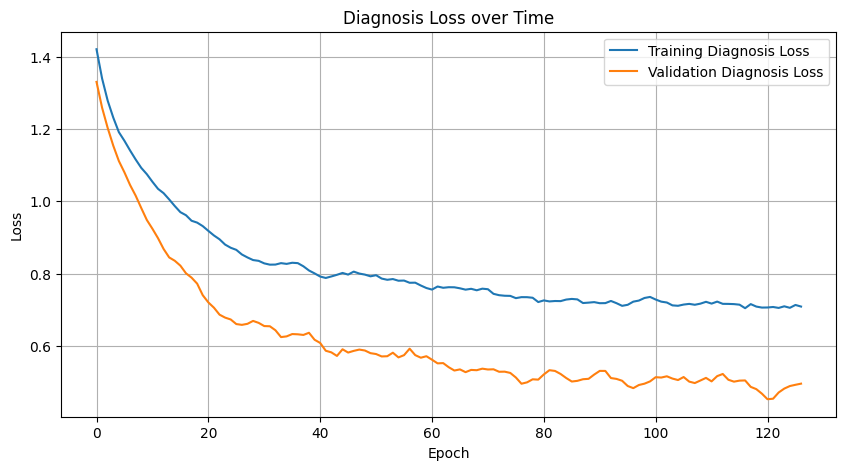

In [ ]:
# Plot Diagnosis
plt.figure(figsize=(10, 5))
plt.plot(smoothed_train_diagnosis, label='Training Diagnosis Loss')
plt.plot(smoothed_val_diagnosis, label='Validation Diagnosis Loss')

plt.title('Diagnosis Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

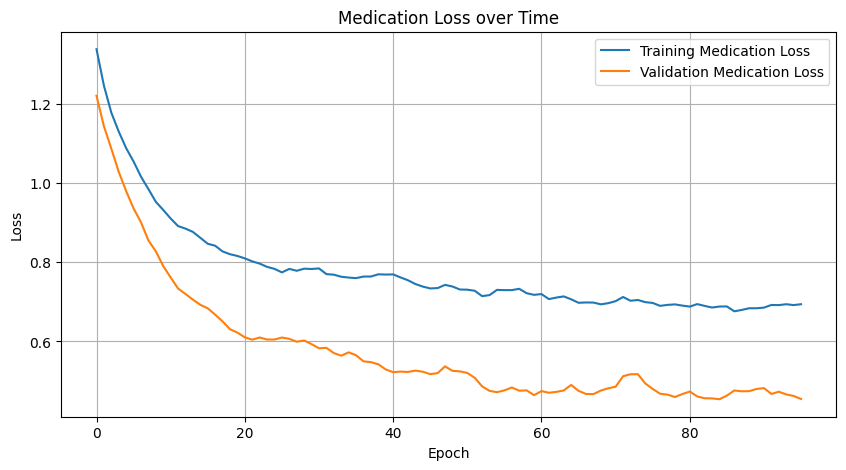

In [ ]:
# Plot Medication Loss
plt.figure(figsize=(10, 5))
plt.plot(smoothed_train_medication, label='Training Medication Loss')
plt.plot(smoothed_val_medication, label='Validation Medication Loss')
plt.title('Medication Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()